## 1. Start server

In [1]:
%%bash
docker run -d -p 9090:80 deeppepserver 

3e70ce560a3d848947d9cb8ea4da7932a03f42c1003ea4a97d150b8dc2e016c4


## 2. Python interface

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

**Load calibration data**

In [3]:
calibration_data = pd.read_csv("data/calibration.csv")
calibration_data.head()

,sequence,retentionTime
0,GNQNNALNSR,13.653333
1,SSGEPTSPSTSSNTR,14.063333
2,KAELEAAK,14.465000
3,SSAGFADK,14.870000
4,DDADEDEEDPDTR,15.246667


**Do calibration prediction on server**

In [4]:
payload = {
    "peptides" : [{"sequence": seq} for seq in calibration_data.sequence]
}

In [5]:
results = requests.post("http://localhost:9090/models/standard_rt/predict", json=payload)

results = pd.DataFrame.from_records(results.json())
results.head()

,rt,sequence,charge
0,-1.685661,GNQNNALNSR,None
1,-1.556427,SSGEPTSPSTSSNTR,None
2,-1.720362,KAELEAAK,None
3,-1.607995,SSAGFADK,None
4,-1.463463,DDADEDEEDPDTR,None


**Build calibration model**

In [6]:
cal_line = LinearRegression()
cal_line.fit(calibration_data.loc[:, ["retentionTime"]], results.rt)

LinearRegression()

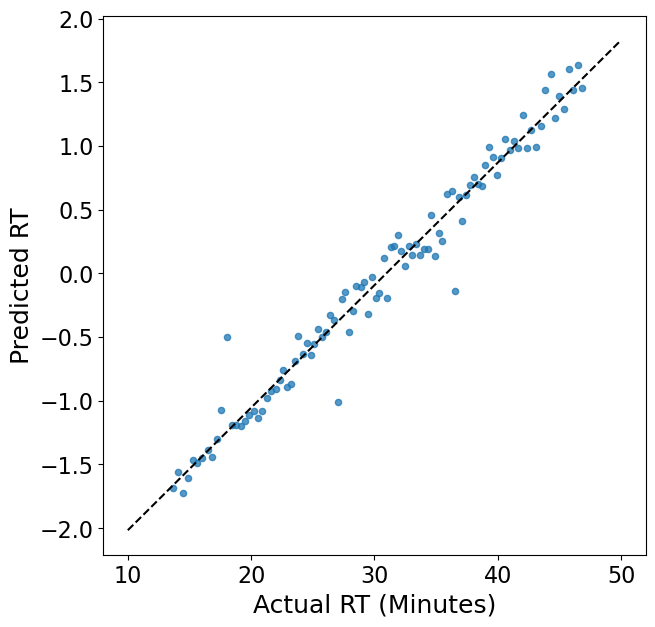

In [7]:
plt.figure(figsize=[7, 7])

plt.scatter(
    x=calibration_data.retentionTime,
    y=results.rt,
    s=20,
    alpha=.75
)

m = cal_line.coef_[0]
b = cal_line.intercept_
plt.plot([10, 50],
         [m * 10 + b, m * 50 + b],
         color="black",
         linestyle="--")

plt.tick_params(labelsize=16)
plt.xlabel("Actual RT (Minutes)", size=18)
plt.ylabel("Predicted RT", size=18)

plt.show()

**Predict on new peptides**

In [8]:
to_predict = ["WVTFISLLLLFSSAYSRGVFRRDTHK", "SEIAHRFK", "DLGEEHFK", "GLVLIAFSQYLQQCPFDEHVK"]
payload = {
    "peptides" : [{"sequence": seq} for seq in to_predict]
}

In [9]:
results = requests.post("http://localhost:9090/models/standard_rt/predict", json=payload)

results = pd.DataFrame.from_records(results.json())
results

,rt,sequence,charge
0,2.422704,WVTFISLLLLFSSAYSRGVFRRDTHK,None
1,-1.532903,SEIAHRFK,None
2,-1.014002,DLGEEHFK,None
3,2.208428,GLVLIAFSQYLQQCPFDEHVK,None


In [10]:
m = cal_line.coef_[0]
b = cal_line.intercept_
results["realRT"] = (results.rt - b)/m

results

,rt,sequence,charge,realRT
0,2.422704,WVTFISLLLLFSSAYSRGVFRRDTHK,None,56.159659
1,-1.532903,SEIAHRFK,None,15.023634
2,-1.014002,DLGEEHFK,None,20.419903
3,2.208428,GLVLIAFSQYLQQCPFDEHVK,None,53.931306
